<a href="https://colab.research.google.com/github/stmarple/MachineLearningWithTensorFlow/blob/master/FFNN_MNST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST (aka Modified National Institute of Standards and Technology Database) 
is a large database of handwritten digits used for training various image processing systems.
https://en.wikipedia.org/wiki/MNIST_database

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

### **Load and Prepare the MNIST Dataset**

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


### **Build the `tf.keras.Sequential` model by stacking layers**

In [0]:
modelA = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

modelA.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **Train and evaluate the model**
Before we begin, we should go over a few important **hyperparameters**:

1. epoch, which is the total training sequences
2. batch_size, which is the training batch size
3. display_freq, which is the frequency of results displaying
4. learning_rate, which is the initial optimization learning rate

see https://www.easy-tensorflow.com/tf-tutorials/neural-networks/two-layer-neural-network?view=article&id=124:two-layer-neural-network for more information.

In [67]:
historyA = modelA.fit(x_train, y_train, epochs=5)
loss, accuracy  = modelA.evaluate(x_test,  y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.2486 - acc: 0.9278
Epoch 2/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1147 - acc: 0.9657
Epoch 3/5
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0811 - acc: 0.9750
Epoch 4/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0643 - acc: 0.9800
Epoch 5/5
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0520 - acc: 0.9832
10000/10000 - 0s - loss: 0.0702 - acc: 0.9779


**Shape**

From here, we can extrapolate that the training data set has 60,000 samples of images with the dimensions 28 X 28.  We also see that the test sample is composed of 10,000 samples of images of the same dimensions.

In [68]:
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (60000, 28, 28)
Test data shape:  (10000, 28, 28)


**Flatten Images**

The image vector size is the square units of each image.  In this case, 28 * 28, or 784.   
As we saw above, x_train = [60000, 28, 28], so x_train[0] is equal to our sample size, or 60,000.    
As the section says, we are trying to flatten this image.  Rather than being 3 dimensional 60k X 28 X 28,
we are flattening the image population down to area.  So we will be down to (sample size, area) for each: training set and test set.

In [0]:
img_vector_size = 28**2
x_train = x_train.reshape(x_train.shape[0], img_vector_size)
x_test = x_test.reshape(x_test.shape[0], img_vector_size)

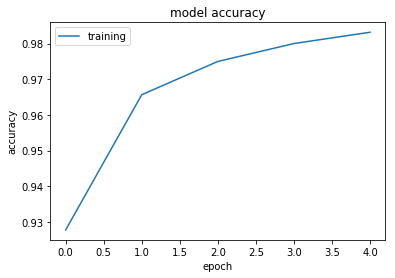

Test loss: 0.0702
Test accuracy: 0.978


In [70]:
import matplotlib.pyplot as plt

plt.plot(historyA.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


*** Now that looks like some good accuracy, with small amounts of test loss! ***

Let's see what it looks like when applied to a hand-written digit...

In [0]:
from random import randint,sample

def test_model(img):
  plt.figure
  plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
  pred = modelA.predict(x_test[img].reshape(1, 28, 28))
  return pred.argmax()

5


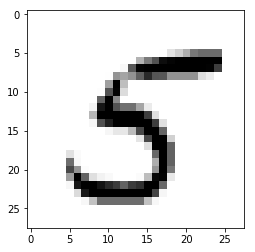

In [72]:
img = randint(1,5000)
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = modelA.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())

*** Looks like this classifies these digits pretty well! ***
# In this next section... 
We will discuss alternate methods of achieving similiar success.  We will look to add nodes and layers, we will choose different optimizers and activation functions and see how that changes the outcome.  We will also go step-by-step on the models work, what each optimizer and activation functions are [that we may use in a problem like this], as well as how the steps are calculated to get a decent understanding on how the model works behind the scenes to enable us to build a foundation for understanding machine learning.



---



# Classification of MNIST Digits
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 

Before we get started, there a just few things we should talk about:  
* **Training data** is the data that our model will be learning from
* **Test data** is the data that is kept a secret until after the model has been trained, and then evaluated against
* A **loss function** is used to quantify how accurate our model's predictions are. 
  These are the amount of error involved.  Some typical loss functions are:
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - Mean Bias Error (MBE)
  - Cross Entropy Loss / Negative Log Likelihood
  
  Many of these I have seen in my studies in Statistics
* An **optimization algorithm** controls the weights, that are adjusted during training.



For more information on loss functions, you can find it here:

https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23


### Calculating Cross Entropy Loss
Since Cross Entropy Loss is the most common setting for classification problems, we will take a closer look at its calculation.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

# [Categorical] Cross Entropy:
## H(p, q) = E<sub>p</sub> [ -log q(x) ] = -$\sum_{i}^C$ p<sub>i</sub>(x) * Log q<sub>i</sub>(x)
Where:
* p is the true probability, given the distribution
* q is the predicted value of the current model
* C is the number of classes, which in our digit classification problem, would be 10
* The above formula is how we find it in many websites.  However, the log is actually base e, not implied base 10, so it should actually be log<sub>e</sub> , or LN. So from now on, in this document, LN is how I'll be writing it; to avoid further confusion.

### _So, let's try to understand this a bit_
 
Say we have an image of digit 2.
Each image can only be entirely one number on a scale of 0 to 9. 

#### Therefore our vector would look like this: 

> p<sub>1</sub> = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

There is 0 probability of being any other number but the one the image is supposed to be.

### Now, let's say we have a machine learning model that classifies the image with probabilities of:

> q<sub>1</sub> = [0.0, 0.0, 0.65, 0.15, 0.0, 0.0, 0.0, 0.20, 0.0, 0.0]

Cross entropy can be calculated on this single image as:

## -$\sum_{i}^C$ p<sub>i</sub>(x) * LN q<sub>i</sub>(x)

= - (0 * LN(0) + 0 * LN(0) + 1 * LN(0.65) + 0 * LN(0.15) + 0 * LN(0) + 0 * LN(0.20) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0))

= - (LN(0.65))

= 0.43078

### Now, lets say the model was able to get better and classifies the probabilies of this image as:
q<sub>1</sub> = [0.0, 0.0, 0.95, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

So, 

## -$\sum_{i}^C$ p<sub>i</sub>(x) * LN q<sub>i</sub>(x) 

= - (0 * LN(0) + 0 * LN(0) + 1 * LN(0.95) + 0 * LN(0.05) + 0 * LN(0) + 0 * LN(0.20) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0) + 0 * LN(0))

= - (LN(0.95))

= 0.05129

**This is much better!**

#### If you would like to get more information on this, see: 
* https://en.wikipedia.org/wiki/Cross_entropy 
* https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* https://medium.com/activating-robotic-minds/demystifying-cross-entropy-e80e3ad54a8
* A Questionable StackOverflow CE function: https://stackoverflow.com/questions/49473587/how-to-compute-log-loss-same-as-cross-entropy

In [74]:
def cross_entropy(x, y):
    x = [element if element > 0 else 1 for element in x] # replace prediction probabilities of 0 to prevent LN(0), which is undefined.  Instead replace LN(1) = 0, which cancels out the term anyway
    print(x)
    pred = np.array(x)
    targ = np.array(y)
    
    N = pred.shape[0] # A stack overflow divided by this number, which seems to conflict with my research (see above)
    return -np.sum(targ*np.log(pred))

predictions1 = [0.0, 0.0, 0.65, 0.15, 0.0, 0.20, 0.0, 0.0, 0.0, 0.0]
targets1     = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

cross_entropy(predictions1, targets1)

[1, 1, 0.65, 0.15, 1, 0.2, 1, 1, 1, 1]


0.4307829160924542

In [75]:
predictions2 =  [0.0, 0.0, 0.95, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
targets2     =  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

cross_entropy(predictions2, targets2)

[1, 1, 0.95, 0.05, 1, 1, 1, 1, 1, 1]


0.05129329438755058

# Example 2: Building a Highly Accurate Image Classifification Model Step-by-Step
## Create a Vector

In [76]:
import keras
from keras.datasets import mnist

# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training label shape: '   , y_train.shape) # 60000 numbers (all 0-9)
print('First 5 training labels: ', y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('First 5 training lables as one-hot encoded vectors:\n', y_train[:5])


Training label shape:  (60000,)
First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


The **number of classes** represents the number of unique digits we have.  This will be the number of categories we can split them up into.  This number represents the number of output nodes or probabilities.

### For fully connected neural networks, there are three essential questions that define the network’s architecture:
1. How many layers are there?
2. How many nodes are there in each of those layers?
3. What transfer/activation function is used at each of those layers?

### There are 2 factors that contribute to the performance of a neural network: 
* The loss function  
* The optimization algorithm used

Per the article mentioned above, the author selects:
* A *common loss function*: **the categorical cross entropy** and 
* One of the simpler *optimization alogorithms*: **the stocastic gradient descent (SGD)**

**What is cross entropy loss?**  It is a log loss that measures the performance of a classification model whose output is based on a probability between 0 and 1.

More information on loss functions and optimiizers can be found here: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd

## Creating First Model
Dense layers are "fully connected" layers
Documentation: https://keras.io/models/sequential/

* "The sequential model is a linear stack of layers" (https://keras.io/getting-started/sequential-model-guide/)

* The input layer requires the special input_shape parameter which should match the shape of our training data.
* The image_size is a created by flattening an image to 28 X 28 or 28<sup>2</sup>  = 784
* This model has a single hidden layer, that has 32 nodes, or 32 biases using the sigmoid activation function
* And, since there are 784 square units, on 1 layer, that has 32 nodes, there are 784 x 1 x 32 = 25,088 weights, where weights represent the number of pixels
* Therefore, there are 25,088 + 32 biases = 25,120 parameters
* There are 32 x 10, or 320 weights from hidden layer to output layer.
* Each of the 10 nodes adds a single bias >> 25,120 par + 320 weights + 10 nodes = 25,450 total parameters



In [77]:
from keras.layers import Dense, Flatten 
from keras.models import Sequential 

image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_39 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### This model contains a special activation function: the softmax.
What makes it special is that it normalizes the values from the 10 output nodes in such a way that:
* all the values are between 0 and 1
* the sum of all 10 values = 1

To put it another way, Softmax "calculates the probabilities distribution of the event over 'n' different events".  In this case, there are 10 possible probabilities, with the largest as the prediction vector.  These probabilities "will be helpful when determining the target class for the given inputs".

More information on activation functions can be found here:
https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html


## Train and Evaluate The Model

In [78]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.05)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Train on 57000 samples, validate on 3000 samples
Epoch 1/5
57000/57000 [==============================] - 2s 37us/step - loss: 1.4052 - acc: 0.6486 - val_loss: 0.9897 - val_acc: 0.8227
Epoch 2/5
57000/57000 [==============================] - 1s 20us/step - loss: 0.8979 - acc: 0.8220 - val_loss: 0.6918 - val_acc: 0.8913
Epoch 3/5
57000/57000 [==============================] - 1s 20us/step - loss: 0.7028 - acc: 0.8606 - val_loss: 0.5579 - val_acc: 0.9053
Epoch 4/5
57000/57000 [==============================] - 1s 19us/step - loss: 0.5961 - acc: 0.8748 - val_loss: 0.4819 - val_acc: 0.9063
Epoch 5/5
57000/57000 [==============================] - 1s 20us/step - loss: 0.5295 - acc: 0.8834 - val_loss: 0.4395 - val_acc: 0.9040


### Graph That

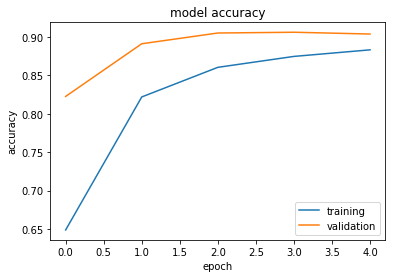

Test loss: 0.503
Test accuracy: 0.885


In [79]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Create, Test, Evaluate, and Graph Again
This time, rather than having a single layer with only 32 nodes, let's increase that to 128 nodes

In [91]:
image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_size,))) # increase from 32 nodes to 128 **
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_47 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 3s 53us/step - loss: 0.9938 - acc: 0.7466 - val_loss: 0.5448 - val_acc: 0.8815
Epoch 2/5
54000/54000 [==============================] - 2s 36us/step - loss: 0.5232 - acc: 0.8720 - val_loss: 0.3972 - val_acc: 0.9067
Epoch 3/5
54000/54000 [==============================] - 2s 36us/step - loss: 0.4215 - acc: 0.8931 - val_loss: 0.3345 - val_acc: 0.9187
Epoch 4/5
54000/54000 [==============================] - 2s 32us/step - loss: 0.3699 - acc: 0.9042 - val_loss: 0.2999 - val_acc: 0.9232
Epoch 5/5
54000/54000 [==============================] - 2s 31us/step - loss: 0.3359 - acc: 0.9103 - val_loss: 0.2764 - val_acc: 0.9273


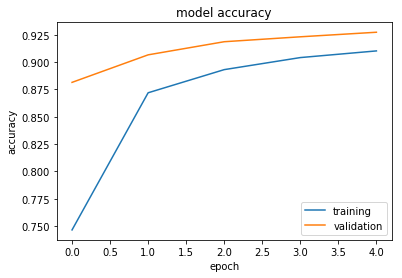

Test loss: 0.31
Test accuracy: 0.918


In [92]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

It looks like the training model has gotten much better.  However, there is still much to be done about the test loss of more than 32%.

## Let's see what this model can predict...

1


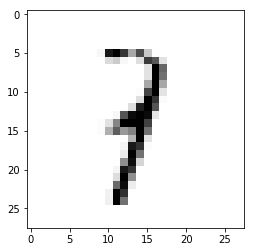

In [89]:
img = 1500
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = model.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())

*** Looks like we still have some work to do! ***

This image is obviously not a 1.  We will look to increase accuracy in the next section.

## Network Depth and Layer Width
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 **continues...**


### In this section, we will be adding layers and determining whether or not there is a positive impact on our model

In [0]:
image_size = 784 # 28*28
num_classes = 10 # ten unique digits

def create_depth(layer_sizes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(units=128, activation='sigmoid', input_shape=(image_size,))) # increase from 32 nodes to 128 **
    
    for layer_size in layer_sizes[1:]:
      model.add(Dense(units=num_classes, activation='sigmoid'))
    
    model.add(Dense(units=num_classes, activation='softmax'))
    return model
    
def eval(model, batch_size=128, epochs=5):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=False)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

### As we can see in the next cells, added hidden layers with sigmoid activation functions and 32 nodes, doesn't seem to help us on the quest to best accuracy.  We may need to consider tweaking for at least some positive change

Model with 1 hidden layer


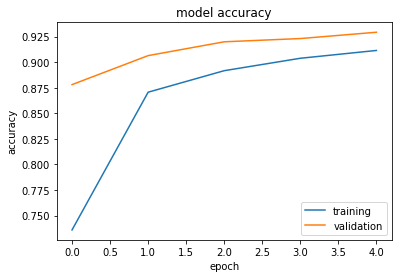

Test loss: 0.309
Test accuracy: 0.921

Model with 2 hidden layers


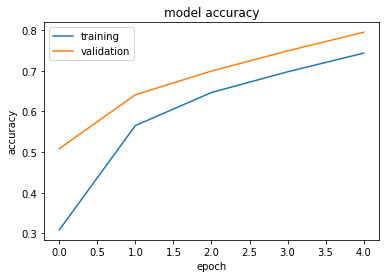

Test loss: 1.23
Test accuracy: 0.772

Model with 3 hidden layers


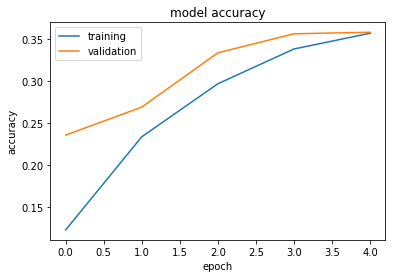

Test loss: 2.09
Test accuracy: 0.359



In [131]:
for layers in range(1,4):
    mod = create_depth([32] * layers)
    if layers == 1:
        print(f'Model with{layers: 1} hidden layer')
    else:
        print(f'Model with{layers: 1} hidden layers')
    eval(mod)
    print()

As you can see, the current model is using:
* SGD, or stochastic gradient descent, is a system or process that selects a few samples at random for each iteration, rather than selecting the entire dataset.  SGD uses a single sample, ie a batch of 1, to perform each iteration.  The sample is then shuffled and selected for the iteration.  Now, let's take a look at the SGD algorithm: 

> for i in range( m ):

> > $\theta$<sub>j</sub> = $\theta$<sub>j</sub> - $\alpha$ * ( $\hat{y}$<sup>i</sup> - y<sup>i</sup> ) * x<sub>j</sub><sup>i</sup> 

* loss = categorical_crossentropy
* The create_depth function will create a multilayer perceptron with a selected array of sizes, each with 32 nodes
* As we can see from the results, as soon as an additional layer was added, our model immediately became ***overfit***.*

